---


Test MSE      : 2.070892e-06
Test Max |err|: 5.308021e-03


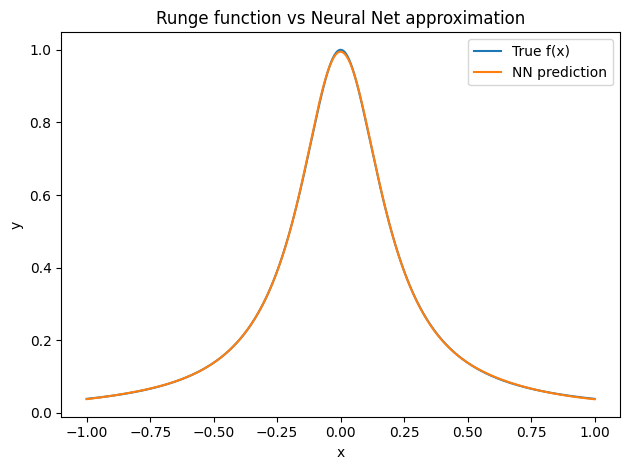

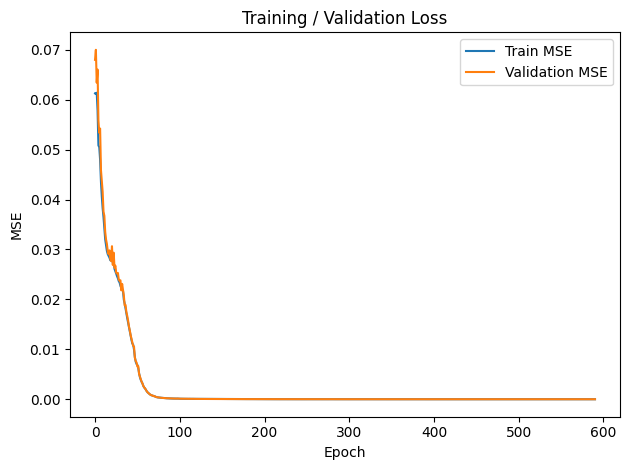

In [5]:
# Runge function approximation with a small neural network (PyTorch)
# 會畫兩張圖：f(x) vs NN、loss curves；並列印 MSE / Max error
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# ---------- config ----------
seed = 42
n_train, n_val, n_test = 256, 256, 1000
hidden = 64
lr = 2e-3
weight_decay = 1e-5
epochs = 800
patience = 80
device = "cpu"

# ---------- utils ----------
torch.manual_seed(seed)
np.random.seed(seed)

def f(x):
    return 1.0 / (1.0 + 25.0 * x**2)

# 建資料（均勻抽樣；想更漂亮可改用 Chebyshev 節點）
x_train = np.random.uniform(-1.0, 1.0, (n_train, 1))
x_val   = np.random.uniform(-1.0, 1.0, (n_val, 1))
x_test  = np.linspace(-1.0, 1.0, n_test).reshape(-1, 1)
y_train, y_val, y_test = f(x_train), f(x_val), f(x_test)

toT = lambda a: torch.from_numpy(a).float().to(device)
Xtr, Ytr = toT(x_train), toT(y_train)
Xva, Yva = toT(x_val),   toT(y_val)
Xte, Yte = toT(x_test),  toT(y_test)

train_dl = DataLoader(TensorDataset(Xtr, Ytr), batch_size=64, shuffle=True)

class MLP(nn.Module):
    def __init__(self, h=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, h), nn.Tanh(),
            nn.Linear(h, h), nn.Tanh(),
            nn.Linear(h, 1)
        )
    def forward(self, x): return self.net(x)

model = MLP(hidden).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.MSELoss()

# ---------- train with early stopping ----------
train_losses, val_losses = [], []
best_val = float("inf"); best_state = None; since_best = 0

for ep in range(1, epochs+1):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb); loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()

    model.eval()
    with torch.no_grad():
        tr = loss_fn(model(Xtr), Ytr).item()
        va = loss_fn(model(Xva), Yva).item()
    train_losses.append(tr); val_losses.append(va)

    if va < best_val - 1e-7:
        best_val = va
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        since_best = 0
    else:
        since_best += 1
        if since_best >= patience:
            break

if best_state is not None:
    model.load_state_dict(best_state)

# ---------- evaluate ----------
model.eval()
with torch.no_grad():
    y_pred = model(Xte).cpu().numpy()

mse = float(np.mean((y_pred - y_test)**2))
max_err = float(np.max(np.abs(y_pred - y_test)))
print(f"Test MSE      : {mse:.6e}")
print(f"Test Max |err|: {max_err:.6e}")

# ---------- plots ----------
# 1) f(x) vs prediction
plt.figure()
plt.plot(x_test.ravel(), y_test.ravel(), label="True f(x)")
plt.plot(x_test.ravel(), y_pred.ravel(), label="NN prediction")
plt.title("Runge function vs Neural Net approximation")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.tight_layout()
plt.show()

# 2) loss curves
plt.figure()
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.title("Training / Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout()
plt.show()
